# EX2 - part 2: auto-regressive language model (GPT2)

In [1]:
# runtime environment setup:
import os
import sys

RunningInCOLAB = 'google.colab' in str(get_ipython())

print(f'Running in colab = {RunningInCOLAB}')

if RunningInCOLAB:
    os.system("pip install wandb -q")

    from google.colab import drive
    drive.mount('/content/drive')

    sys.path.append('./drive/MyDrive/aml/minGPT/')
    sys.path.append('./drive/MyDrive/aml/')

# for evaluation and plots, after traning - change 'RETURN_ATTENTIONS' parameter in 'mingpt/model.py' to True

Running in colab = False


In [2]:
# imports:
import torch
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch.nn.functional as F
from torch.utils.data import Dataset
from matplotlib.collections import PatchCollection

In [3]:
# logger setup:
import wandb
from personal import WANDB_API_KEY

if RunningInCOLAB:
    wandb.login(key=WANDB_API_KEY, relogin=True)

In [4]:
# GPT modules import:
from mingpt.model import GPT
from mingpt.utils import set_seed
from mingpt.bpe import get_encoder
from mingpt.trainer import Trainer

In [5]:
# run setup:
set_seed(3407)
gpu = torch.device('cuda:0')

In [6]:
# Dataset:
class AlicDataset(Dataset):
    def __init__(self, block_size, vocab_size=50257, path='alice_in_wonderland.txt'):
        self.block_size = block_size
        self.vocab_size = vocab_size
        self.encoder = get_encoder()

        if RunningInCOLAB:
            path = os.path.join('./drive/MyDrive/aml', path)

        with open(path) as f:
            text = ' '.join((f.read().replace('\n', ' ').replace('\r', ' ').replace('\t', ' ')).split())

        self.tokens = torch.tensor(self.encoder.encode(text), dtype=torch.long)

    def __len__(self):
        return len(self.tokens) - (self.block_size + 1) # todo check + 1 for all block size appearances

    def __getitem__(self, idx):
        slice_start = idx
        slice_end = idx + self.block_size

        input_seq = self.tokens[slice_start: slice_end]
        output_seq = self.tokens[slice_start + 1: slice_end + 1]

        return input_seq, output_seq


# create a dataset
train_dataset = AlicDataset(block_size=64)

In [7]:
# create a GPT instance
model_config = GPT.get_default_config()
model_config.model_type = 'gpt2'
model_config.vocab_size = train_dataset.vocab_size
model_config.block_size = train_dataset.block_size
model = GPT(model_config)

number of parameters: 123.70M


In [8]:
# create a Trainer object
train_config = Trainer.get_default_config()
train_config.learning_rate = 5e-4 # the model we're using is so small that we can go a bit faster
train_config.batch_size = 32
train_config.max_iters = 2000
train_config.num_workers = 0

if RunningInCOLAB:
    wandb.init(project="ex1", config=train_config, name='gpu_train_colab')
trainer = Trainer(train_config, model, train_dataset)

running on device cpu


In [9]:
# for training RETURN_ATTENTIONS needs to be False on model.py
load = True
save = False

def batch_end_callback(trainer):
    if trainer.iter_num % 10 == 0:
        print(f"iter_dt {trainer.iter_dt * 1000:.2f}ms; iter {trainer.iter_num}: train loss {trainer.loss.item():.5f}")
        wandb.log({"train_loss" : trainer.loss.item()})
        
trainer.set_callback('on_batch_end', batch_end_callback)

weights_path = 'alice_model.pth'
if RunningInCOLAB:
    weights_path = os.path.join('./drive/MyDrive/aml', weights_path)

if load:
    if RunningInCOLAB:
        model.load_state_dict(torch.load(weights_path, gpu))
    else:
        model.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu')))
else:
    trainer.run()
    if save:
        torch.save(model.state_dict(), weights_path)


In [10]:
model.eval()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(64, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): ModuleDict(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          (act): NewGELU()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in

In [11]:
# RETURN_ATTENTIONS needs to be True on model.py
# question 2
with torch.no_grad():
    sent = """Repeat, "I AM A LITTLE, SQUIRREL HOLDING, A WALNUT,"' said the Caterpillar. Alice folded her hands, and began:-- """
    encoder = get_encoder()
    input_sec = torch.tensor(encoder.encode(sent), dtype=torch.long).unsqueeze(0)#.to(gpu)
    print([encoder.decode(token) for token in model.generate(input_sec, 10, do_sample=True)[0].cpu().numpy()])


['Repeat, "I AM A LITTLE, SQUIRREL HOLDING, A WALNUT,"\' said the Caterpillar. Alice folded her hands, and began:--  crawled changed to the bread-and-butter']


In [13]:
# RETURN_ATTENTIONS needs to be False on model.py
def inversion(model_, dataset, *, target_str, num_steps = 500,
              learning_rate = 0.1, device: torch.device = torch.device('cpu')):

    target_sentence = torch.tensor(dataset.encoder.encode(target_str),
                                   dtype=torch.long)[None,...].to(device)

    # sample a random latent vector
    input_sentence = torch.normal(0, 1, (1, 9, 768), device=device, requires_grad=True)

    # Initialize GD optimizer
    optimizer = torch.optim.Adam([input_sentence], betas=(0.9, 0.999), lr=learning_rate)

    losses = []
    # Run GD
    for step in tqdm(range(num_steps)):
        logits, loss = model_(None, targets=target_sentence, latent_vector=input_sentence)
        losses.append(float(loss))

        # decode the generated sentence
        probs = F.softmax(logits, dim=-1)
        _, idx_next = torch.topk(probs, k=1, dim=-1)
        generated_sentence = dataset.encoder.decode(idx_next[0,:,0].cpu().numpy())

        # report the loss
        if step % 25 == 0:
            # show the sentence that was generated the step
            print('current sentence for latent:', generated_sentence)

        if generated_sentence == target_str:
            print('-' * 50)
            print('Stopped !')
            print('model output: "', generated_sentence, '"')
            break

        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return input_sentence, losses

input_sentence, losses = inversion(model, train_dataset,
          target_str='I am a little squirrel holding a walnut',
          num_steps=1000)


  0%|          | 0/1000 [00:00<?, ?it/s]

current sentence for latent:  now out on his now of" for so


  3%|▎         | 26/1000 [00:04<02:32,  6.38it/s]

current sentence for latent: quet am a littleney holding a wal?


  5%|▌         | 51/1000 [00:08<02:29,  6.35it/s]

current sentence for latent: I am a little birds holding a walnut


  8%|▊         | 76/1000 [00:12<02:27,  6.26it/s]

current sentence for latent: I am a little clever holding a walnut


  8%|▊         | 79/1000 [00:13<02:33,  6.01it/s]

--------------------------------------------------
Stopped !
model output: " I am a little squirrel holding a walnut "


In [14]:
print(input_sentence)

tensor([[[ 0.8371, -2.7097,  2.5457,  ..., -2.5255,  0.9687, -1.0763],
         [-0.7460,  1.4124,  1.6422,  ..., -1.0766,  0.3521,  0.2970],
         [-0.6000, -0.1209, -0.4295,  ...,  1.5853, -0.6543,  1.8726],
         ...,
         [ 0.8655, -1.3813,  0.2538,  ..., -1.2783,  1.2740,  0.2395],
         [-1.7015, -1.1999, -0.3732,  ...,  0.8111,  1.1715, -1.4626],
         [-2.9633, -0.1542, -3.4524,  ...,  0.8937,  0.2437,  0.4835]]],
       requires_grad=True)


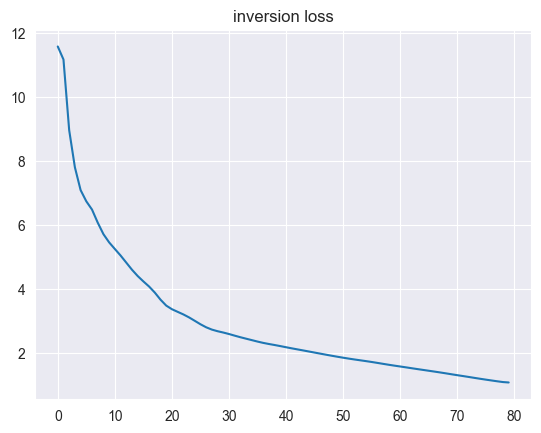

In [15]:
plt.plot(losses)
plt.title('inversion loss')
plt.show()

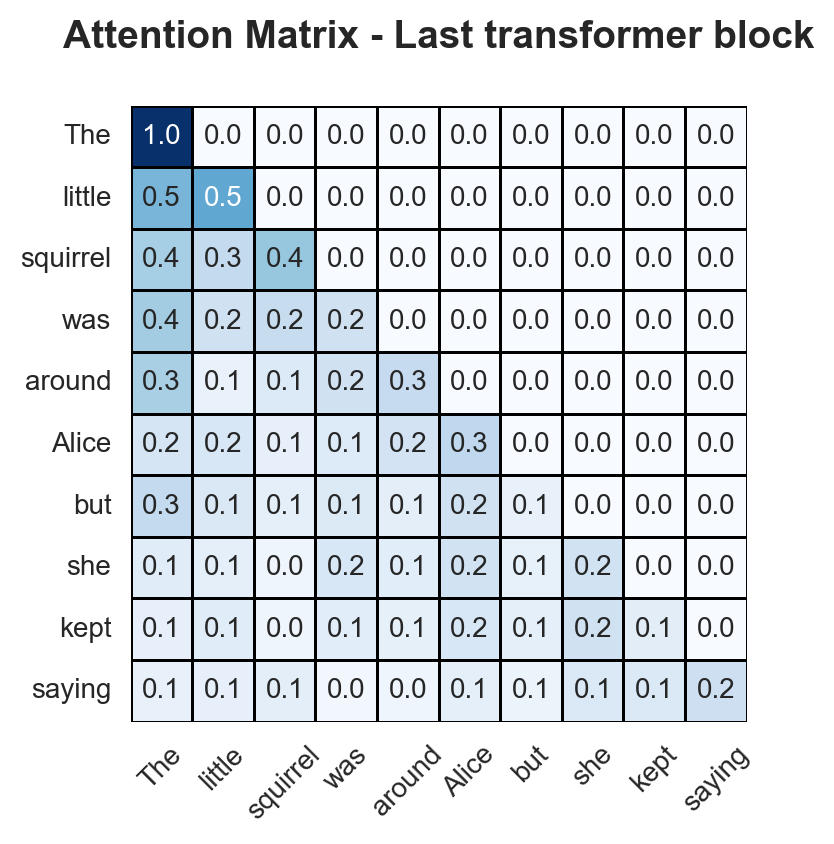

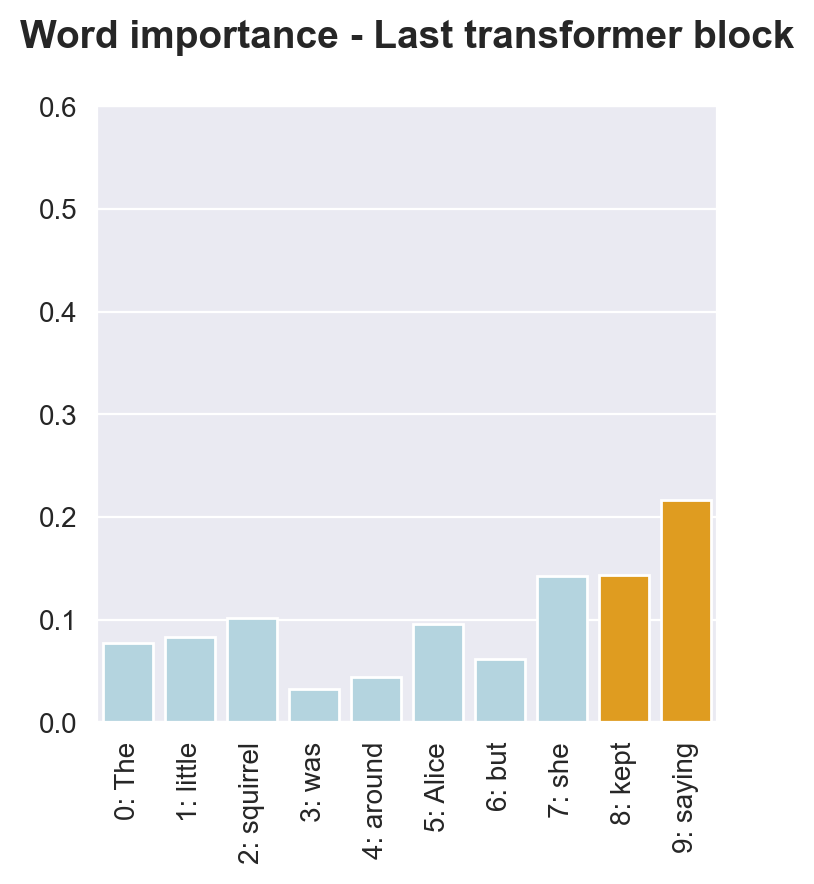

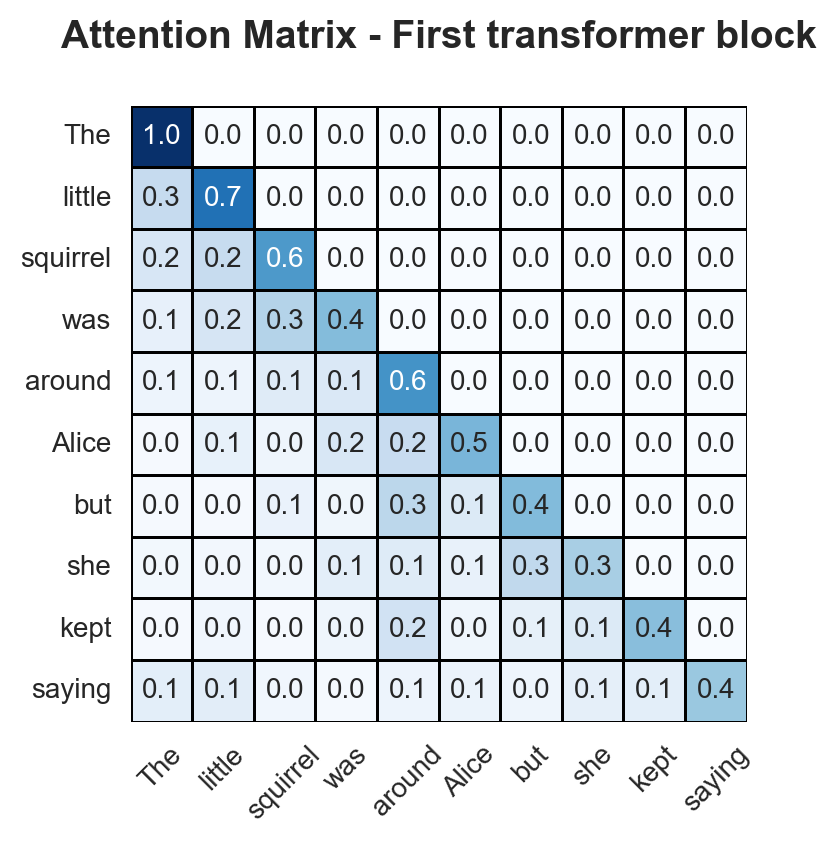

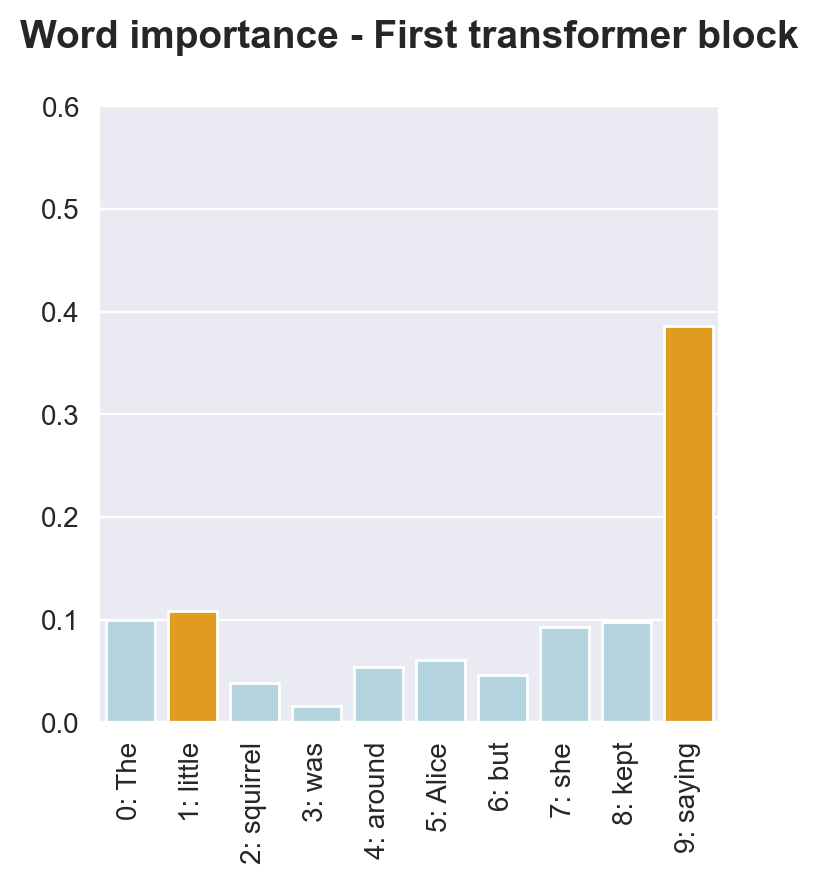

In [12]:
## Question 3:
model.eval()

# a 10-word sentence to check the attention matrix on:
sentence = "The little squirrel was around Alice but she kept saying"

# run the model and collect the attention matrices
with torch.no_grad():
    input_sec = torch.tensor([train_dataset.encoder.encode(sentence)], dtype=torch.long)
    if RunningInCOLAB:
        input_sec = input_sec.to(gpu)
    output_sec, att_mat_lists, _ = model.generate(input_sec, 1, do_sample=True)

decoded_sentence = [train_dataset.encoder.decode(i) for i in output_sec.cpu().numpy()][0].split()

# plot the attention matrix and the word importance:
last_att_matrix = att_mat_lists[0][-1]

plt.figure(figsize=(4, 4), dpi = 200)
ax_last_att = plt.axes()
sns.heatmap(last_att_matrix, ax=ax_last_att, annot=True,
                yticklabels=sentence.split(' '), xticklabels=sentence.split(' '),
                cbar=False, cmap="Blues", fmt='.1f', annot_kws={"size": 10},
                linewidths=0.5, linecolor='black', square=True)
ax_last_att.set_title(f"Attention Matrix - Last transformer block\n",
                      fontweight='bold', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(4, 4), dpi = 200)

word_importance_last_block = last_att_matrix[-1]
color_thresh = np.quantile(word_importance_last_block, 0.8)

ax_last_att_imp = plt.axes()
colors = ['orange' if v > color_thresh else 'lightblue' for v in word_importance_last_block]
sns.barplot(x=[f'{i}: {s}' for i, s in enumerate(sentence.split(' '))],
                y=word_importance_last_block, ax=ax_last_att_imp, palette=colors)
ax_last_att_imp.set_title(f"Word importance - Last transformer block\n",
                          fontweight='bold', fontsize=14)
ax_last_att_imp.set_ylim(0,0.6)
plt.xticks(rotation=90)
plt.show()



# question 4:
plt.figure(figsize=(4, 4), dpi = 200)

first_att_matrix = att_mat_lists[0][0]

ax_first_att = plt.axes()
sns.heatmap(first_att_matrix, ax=ax_first_att, annot=True,
                yticklabels=sentence.split(' '), xticklabels=sentence.split(' '),
                cbar=False, cmap="Blues", fmt='.1f', annot_kws={"size": 10},
                linewidths=0.5, linecolor='black', square=True)
ax_first_att.set_title(f"Attention Matrix - First transformer block\n",
                       fontweight='bold', fontsize=14)
plt.yticks(rotation=0)
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(4, 4), dpi = 200)

word_importance_first_block = first_att_matrix[-1]
color_thresh_first = np.quantile(word_importance_first_block, 0.8)

ax_first_att_imp = plt.axes()
colors_first = ['orange' if v > color_thresh_first else 'lightblue' for v in word_importance_first_block]
sns.barplot(x=[f'{i}: {s}' for i, s in enumerate(sentence.split(' '))],
                y=word_importance_first_block, ax=ax_first_att_imp, palette=colors_first)
ax_first_att_imp.set_title(f"Word importance - First transformer block\n",
                           fontweight='bold', fontsize=14)
ax_first_att_imp.set_ylim(0,0.6)
plt.xticks(rotation=90)
plt.show()


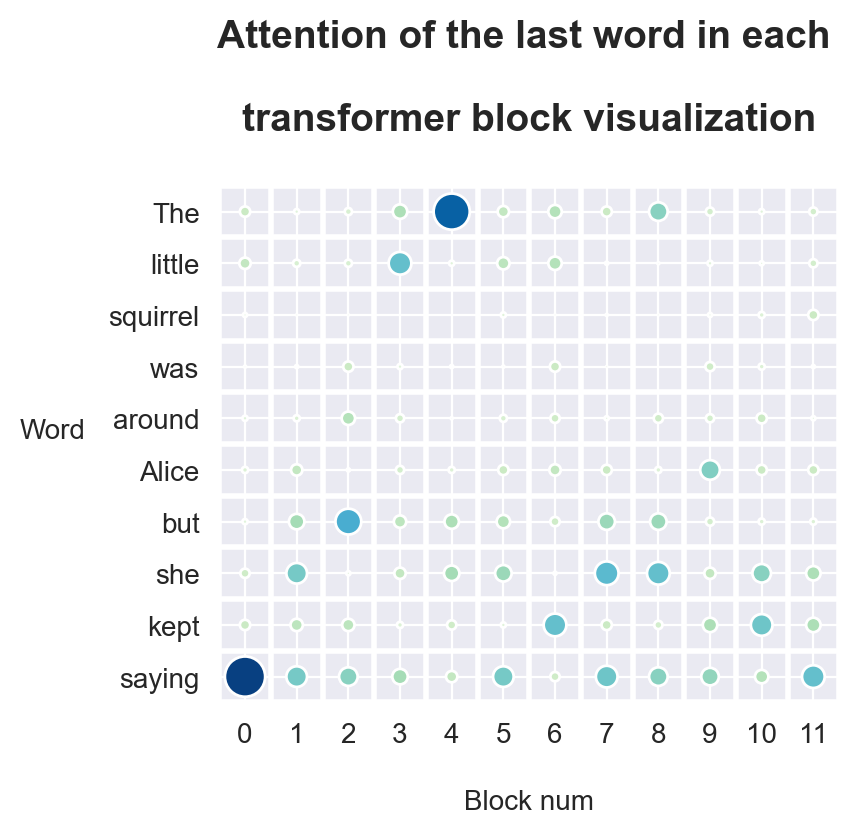

In [13]:
ylabels = sentence.split(' ')[::-1]
xlabels =np.arange(12)

N = len(ylabels)
M = len(xlabels)

x, y = np.meshgrid(np.arange(M), np.arange(N))

fig, ax = plt.subplots(figsize=(4, 4), dpi = 200)

R = np.array([m[-1][::-1].round(2) for m in att_mat_lists[0]]).T
circles = [plt.Circle((j,i), radius=R[i][j]) for i in range(N) for j in range(M)]
col = PatchCollection(circles, array=R.flatten(), cmap='GnBu')
ax.add_collection(col)

ax.set(xticks=np.arange(M), yticks=np.arange(N),
       xticklabels=xlabels, yticklabels=ylabels)
ax.set_xticks(np.arange(M+1)-0.5, minor=True)
ax.set_yticks(np.arange(N+1)-0.5, minor=True)
ax.grid(which='minor', linestyle='-', linewidth=2)
ax.set_aspect('equal')
ax.set_title('Attention of the last word in each \n\ntransformer block visualization',
             pad=20, fontweight='bold', fontsize=14)
ax.set_xlabel('\nBlock num')
ax.set_ylabel('Word', rotation=0, labelpad=20)
plt.show()

The little squirrel was around Alice but she kept saying, `That's right, Five! I wonder if I shall have got


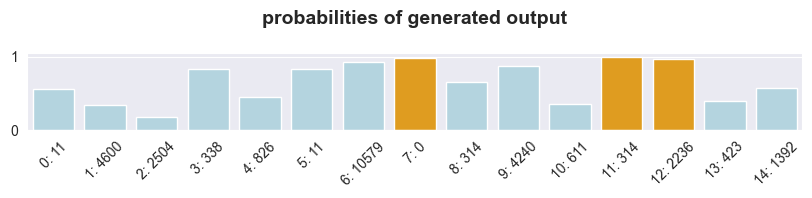

sentence probability is: 0.0004248775658197701


In [14]:
# question 5:
with torch.no_grad():
    input_sec = torch.tensor([train_dataset.encoder.encode(sentence)], dtype=torch.long)
    if RunningInCOLAB:
        input_sec.to(gpu)
    output_sec, att_mat_lists, log_probs = model.generate(input_sec, 15)

decoded = [train_dataset.encoder.decode(i) for i in output_sec.cpu().numpy()][0]
print(decoded)

plt.figure(figsize=(10, 1))

word_prob = np.hstack(log_probs)
color_thresh_first = np.quantile(word_prob, 0.8)

ax_prob = plt.axes()
colors_first = ['orange' if v > color_thresh_first else 'lightblue' for v in word_prob]
sns.barplot(x=[f'{i}: {s}' for i, s in enumerate(output_sec[0][-15:].numpy())],
                y=np.exp(word_prob), ax=ax_prob, palette=colors_first)
ax_prob.set_title(f"probabilities of generated output\n",
                           fontweight='bold', fontsize=14)
plt.xticks(rotation=45)
plt.show()

print(f'sentence probability is: {np.exp(np.hstack(log_probs).sum())}')